<a href="https://colab.research.google.com/github/enjuichang/infoGAN-infotheory/blob/main/InfoGAN_sample_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#InfoGAN sample implementation
**Original Authors: Ben Poole, Kumar Krishna Agrawal**

**Annotators: Enjui Chang, Arnav Hazra**

In this notebook, we documented the codes for InfoGAN implementation and connected it back to the paper and information theory concepts.



In [2]:
# Downgrade Tensorflow to TF1.X
!pip install tensorflow==1.15.5

In [3]:
### Import libraries and data

# Import tensorflow
import tensorflow as tf
slim = tf.contrib.slim
tfd = tf.distributions

# Import data
from tensorflow.examples.tutorials.mnist import input_data

# Import data viz and processing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The first function below is the generator neural network. It is simply two fully connected dense layers on top of two 2D convolutional layers with a sigmoid activation function.

Different from original GANs, the first dense layer is connected with the input variables ($z$ in this function), namely the incompressible noise $z$ and the latent variable vector $c$. This correspond to the InfoGAN architecture where the generator is feed on the predefiend latent variables.

In [4]:
def generator(z, out_activation_fn=tf.nn.sigmoid):
  """
  Generate images from latents.
  ---
  Inputs:
  z (array): all input variables
            (incompressible noise, discrete latents, and continuous latents)
  out_activation_fn: activation function
  
  Outputs:
  net: generator neural network
  """

  with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose],
                      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.conv2d_transpose], kernel_size=4, stride=2):
      net = slim.fully_connected(z, 1024) # Inputs the latent variable vector
      net = slim.fully_connected(net, 7 * 7 * 128)
      net = tf.reshape(net, [-1, 7, 7, 128])
      net = slim.conv2d_transpose(net, 64)
      net = slim.conv2d_transpose(net, 1,
                                  normalizer_fn=None,
                                  activation_fn=None)
      net = out_activation_fn(net)
      return net

The second function is the discriminator function. It takes in the tensor of images and the latent variable dimensions. The neural network itself is simply two 2D convolutional layers and a fully connected dense layer. The outputs are the predicted distribution (real/fake and latent variable posterior).

The addition of InfoGAN is the posterior distribution/logits of the contiunous/discrete latent variables. The results would then be inputted into the auxiliary function for optimizing the latent variables.

In [5]:
def discriminator(x, cat_dim, cont_dim, fix_cont_std=True):
  """
  Discriminate real vs. fake and predict latent variable from an input image.
  
  Input:
    x: Tensor of images
    cat_dim: Dimension of categorical variable
    cont_dim: Number of continuous latent variables
    fix_cont_std: Whether to fix the standard deviation of the approximate
      posterior for the continuous latent variables to 1.0 
      
  Output:
    q_real: predicted distribution over real vs. fake
    q_cat: predicted distribution over categorical variable
    q_cont: predicted distribution over continuous variable
  """
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.leaky_relu):
    with slim.arg_scope([slim.conv2d], kernel_size=4, stride=2):
      net = slim.conv2d(x, 64, normalizer_fn=None)
      net = slim.conv2d(net, 128, normalizer_fn=slim.batch_norm)
      net = slim.flatten(net)
      net = slim.fully_connected(net, 1024, normalizer_fn=slim.batch_norm)

      # Logits for binary real vs. fake GAN discriminator
      logits_real = slim.fully_connected(net, 1, activation_fn=None)
      q_real = tfd.Bernoulli(logits=logits_real)

      # Recognition network for latent variables has an additional layer 
      encoder = slim.fully_connected(net, 128, normalizer_fn=slim.batch_norm)

      # Compute logits for each category of categorical latent
      logits_cat = slim.fully_connected(encoder, cat_dim, activation_fn=None)
      q_cat = tfd.Categorical(logits=logits_cat)

      # Compute mean and variance for Gaussian posterior of continuous latents
      cont_vars = slim.fully_connected(encoder, cont_dim * 2, activation_fn=None)
      cont_mu = cont_vars[:, :cont_dim]
      if fix_cont_std:
        cont_sigma = tf.ones_like(cont_mu)
      else:
        cont_sigma = tf.nn.softplus(cont_vars[:, cont_dim:])
      q_cont = tfd.Normal(loc=cont_mu, scale=cont_sigma)
      return q_real, q_cat, q_cont

The next cells introduces the hyperparameters of the InfoGAN, including the dimensions of the incompressible noise, the latent variables, the $\lambda$ normailization coefficient in $\lambda L_I(G,Q)$, and the learning rate of the generator and discriminator.

In [23]:
# Incompressible noise dimensionality (not reconstructed)
noise_dim = 62
# Dimensionality of the single categorical variable
# cat_dim = 5
cat_dim = 10
# Number of continuous latent variables
cont_dim = 2
# Weighting on InfoGAN regularization term
info_reg_coeff = 1.0
# Generator/discriminator learning rate
gen_lr = 1e-3
disc_lr = 2e-4

In [15]:
# Read image data
NB=128
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In this cell, we preprocess the image data from MNIST data and generate the priors (initial inputs) for initializing the InfoGAN.



In [24]:
# Preprocess Image
tf.reset_default_graph()
images_np = mnist.train.images
images_np = images_np.reshape(-1, 28, 28, 1)
dataset = tf.data.Dataset.from_tensor_slices(images_np)
dataset = dataset.shuffle(100).repeat()
dataset = dataset.apply(
    tf.contrib.data.batch_and_drop_remainder(NB))
images = dataset.make_one_shot_iterator().get_next()

### Generate samples from prior
# Categorical latent variable
z_cat = tfd.Categorical(logits=tf.zeros([NB, cat_dim])).sample()
z_cat_one_hot = tf.one_hot(z_cat, cat_dim)

# Incompressible noise
z_noise = tfd.Uniform(low=-tf.ones([NB, noise_dim]),
                      high=tf.ones([NB, noise_dim])).sample()

# Continuous latent variable
z_cont = tfd.Uniform(low=-tf.ones([NB, cont_dim]),
                     high=tf.ones([NB, cont_dim])).sample()

# Concatenate incompressible noise, discrete latents, and continuous latents
z = tf.concat([z_noise, z_cat_one_hot, z_cont], axis=1)

This next cell constructs the generator and discriminator networks. This simply means it connects the inputs and outputs from the prior to the generator and then to the discriminator and back to the updated priors and generator.

In [ ]:
### Construct generator and discriminator networks
with slim.arg_scope(
    [slim.fully_connected, slim.conv2d_transpose],
    weights_initializer=tf.random_normal_initializer(stddev=0.02)):
  # Initialize weights
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=0.02)):
    # Generator 
    with tf.variable_scope('gnet'):
      with slim.arg_scope([slim.batch_norm], is_training=True):
        generated = generator(z)
    with tf.variable_scope('gnet', reuse=True):
      with slim.arg_scope([slim.batch_norm], is_training=False):
        generated_test = generator(z)
    # Discriminator
    with tf.variable_scope('dnet'): # real data
      d_real, cat_real, cont_real = discriminator(images, cat_dim, cont_dim)
    with tf.variable_scope('dnet', reuse=True): #fake data
      d_fake, cat_fake, cont_fake = discriminator(generated, cat_dim, cont_dim)

This next cell defines the objective function and the InfoGAN loss function. This simply interpreting the InfoGAN formula in tensorflow code:
$$\min_{G,Q}\max_DV_\text{InfoGAN}(D,G,Q) =V(D,G)−λL_I(G,Q)$$

The first part shows the normal GAN objectives and the second part shows the InfoGAN loss function, which is the lof probability addition between the categorical and continous latent variables.

Next, the loss functions for both the generator and discrimator is defined. Lastly, an Adam optimizer was placed for both the discriminator and generator. One thing to note is that in this implementation, the auxiliary function $Q$ is not a neural network.

In [25]:
# Normal GAN objectives
real_labels = tf.ones([NB, 1])
fake_labels = tf.zeros([NB, 1]) 
gan_d_loss = -(tf.reduce_mean(d_real.log_prob(real_labels)) + 
               tf.reduce_mean(d_fake.log_prob(fake_labels)))
gan_g_loss = -tf.reduce_mean(d_fake.log_prob(real_labels))

# InfoGAN loss
log_prob_cat = tf.reduce_sum(cat_fake.log_prob(z_cat)) / NB
log_prob_cont = tf.reduce_sum(cont_fake.log_prob(z_cont)) / NB
infogan_loss = -info_reg_coeff * (log_prob_cat + log_prob_cont)

# Generator and discriminator loss are the same as a GAN but with the added
# regularization to reconstruct a subset of latents from the image
d_loss = gan_d_loss + infogan_loss
g_loss = gan_g_loss + infogan_loss

# Optimization
global_step = tf.train.get_or_create_global_step()
dvars = tf.contrib.framework.get_variables('dnet')
gvars = tf.contrib.framework.get_variables('gnet')
gen_opt = tf.train.AdamOptimizer(gen_lr, 0.5)
disc_opt = tf.train.AdamOptimizer(disc_lr, 0.5)
train_gen_op = gen_opt.minimize(g_loss, global_step, var_list=gvars)
update_ops = (tf.get_collection(tf.GraphKeys.UPDATE_OPS))
with tf.control_dependencies(update_ops + [train_gen_op]):
  train_op = disc_opt.minimize(d_loss, global_step, var_list=dvars)

The next cell is for a function for displaying the images at a specific genration.

In [26]:
# Display images function
from IPython.display import display
plt.ioff()
def display_imgs(gens):
  fig, axs = plt.subplots(1, 5, figsize=(10, 1))
  for i in range(5):
    axs.flat[i].imshow(gens[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off');
  return fig, axs

This next cell is the training of the InfoGAN. 

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 [None, 2, -2.3079224, -2.177484, 4.4854064, 1.4971799, 0.8899839]


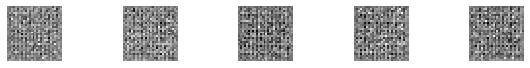

100 [None, 202, -0.4415982, -1.8757763, 2.3173745, 1.0954902, 0.8533721]


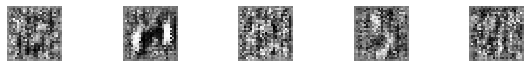

200 [None, 402, -0.19545554, -1.8640509, 2.0595064, 1.1463108, 0.8586408]


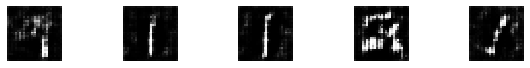

300 [None, 602, -0.13278526, -1.8725519, 2.0053372, 1.1895452, 0.8512777]


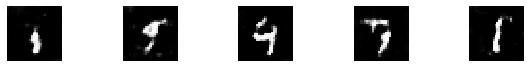

400 [None, 802, -0.08166507, -1.8649216, 1.9465866, 1.168982, 0.85458267]


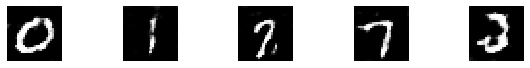

500 [None, 1002, -0.0711355, -1.8779569, 1.9490924, 1.2354735, 0.8285795]


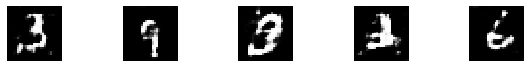

600 [None, 1202, -0.04659212, -1.8770714, 1.9236635, 1.2300115, 0.82713294]


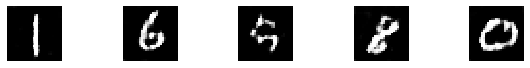

700 [None, 1402, -0.05631575, -1.8778188, 1.9341346, 1.2377033, 0.7918178]


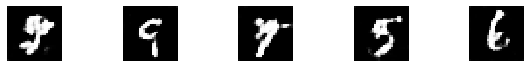

800 [None, 1602, -0.047690824, -1.859899, 1.9075899, 1.2440213, 0.8386011]


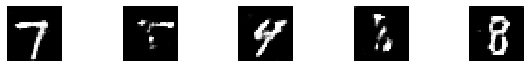

900 [None, 1802, -0.03295339, -1.8623648, 1.8953182, 1.2587123, 0.825626]


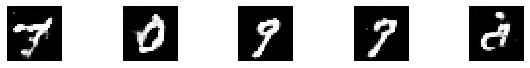

1000 [None, 2002, -0.037470788, -1.8637735, 1.9012443, 1.2632848, 0.7740351]


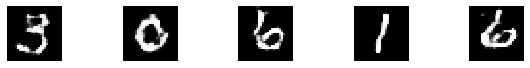

In [27]:
# Training Parameters
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
steps = 1000

# Define output
outs = []

# Training
for i in range(steps+1):
  out = sess.run([train_op, global_step, log_prob_cat, log_prob_cont, infogan_loss, gan_d_loss, gan_g_loss, generated])
  outs.append(out[1:-1])

  # Display image every 100 iteration
  if i % (steps//10) == 0:
    print(i, out[:-1])
    fig, ax = display_imgs(out[-1])
    display(fig)
    plt.close(fig)

The next cell shows the dicriminator loss, generator loss, and InfoGAN loss throughout the training process. This is an important figure as we need to know whether the InfoGAN ended up converging.

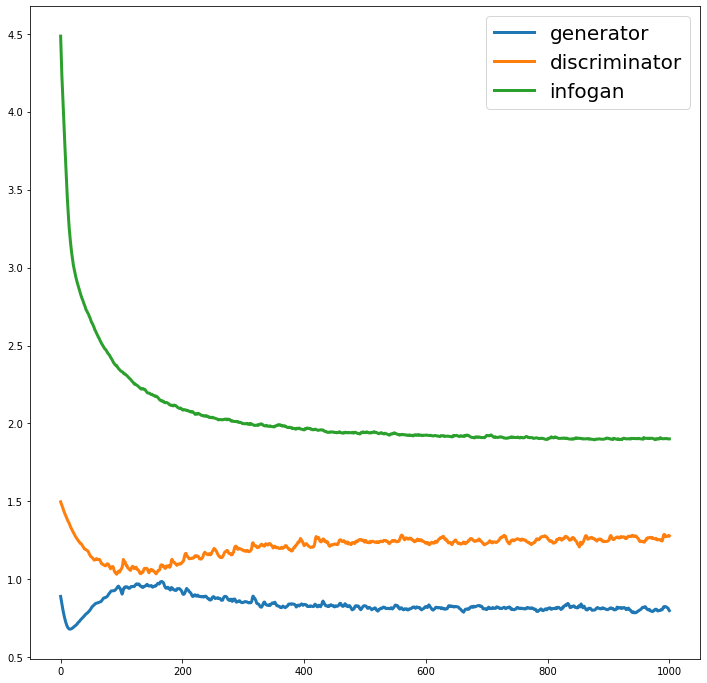

In [28]:
%matplotlib inline

outs = np.array(outs)
figure = plt.figure(figsize=(12, 12))
# Plot the losses
for i in range(1, 4):
  plt.plot(pd.Series(outs[:, -i]).ewm(span=10).mean(), linewidth=3.0);
plt.legend(('generator', 'discriminator', 'infogan'), fontsize=20);

The last cell shows the representation of the contiunous and discrete latent variables after the training.

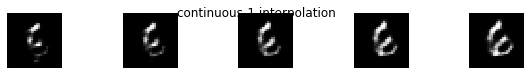

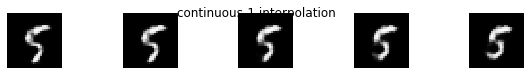

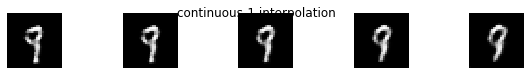

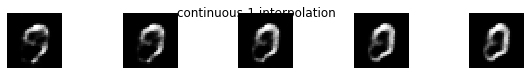

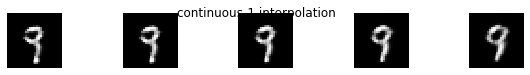

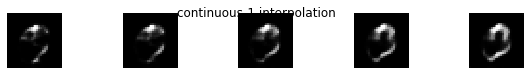

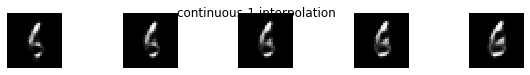

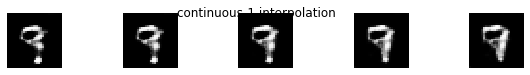

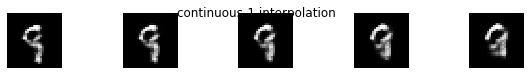

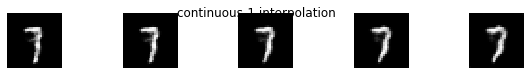

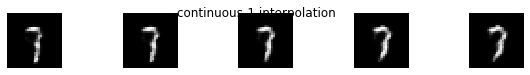

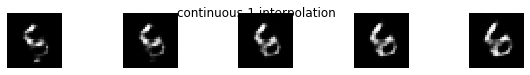

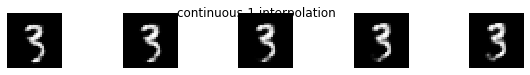

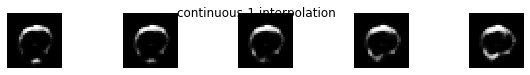

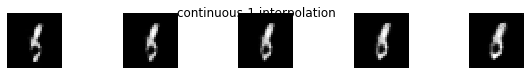

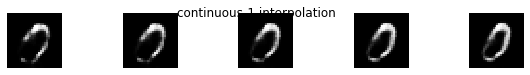

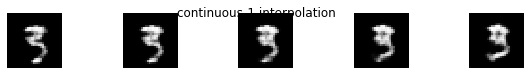

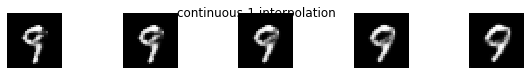

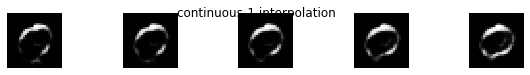

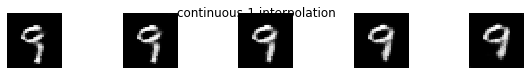

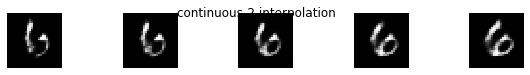

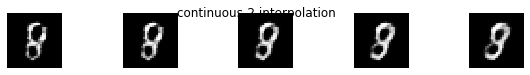

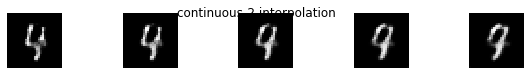

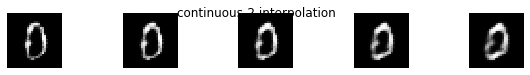

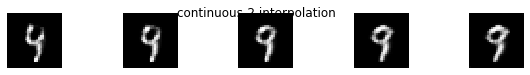

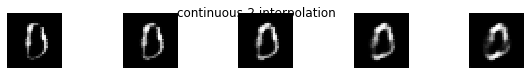

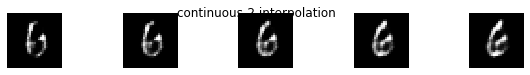

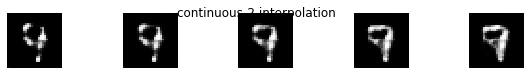

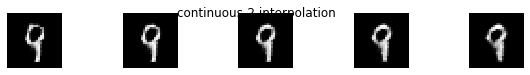

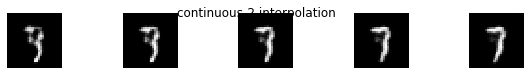

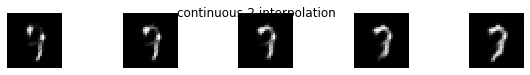

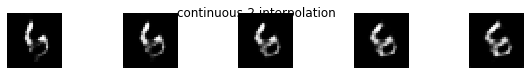

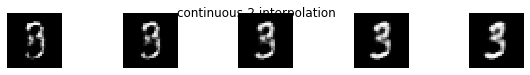

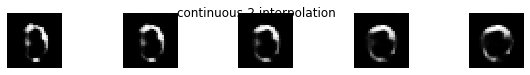

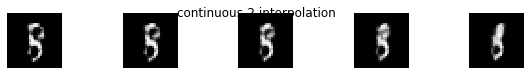

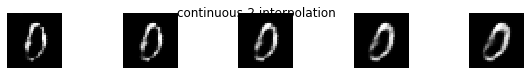

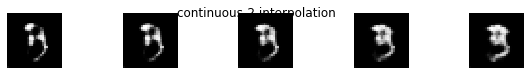

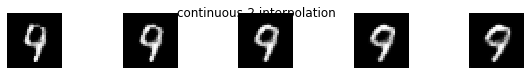

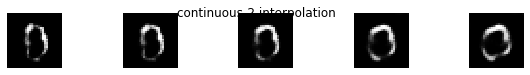

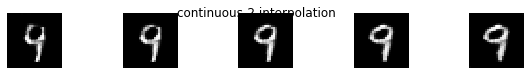

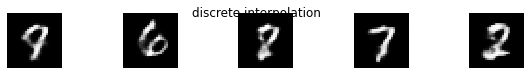

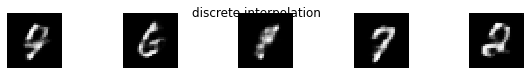

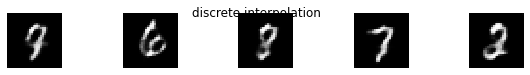

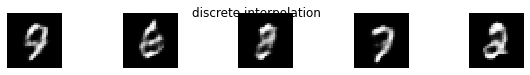

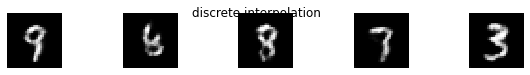

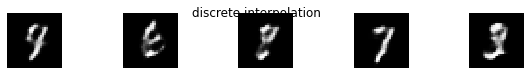

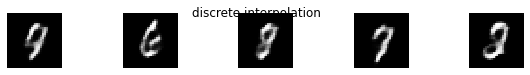

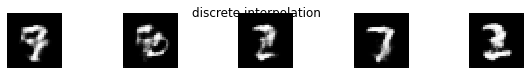

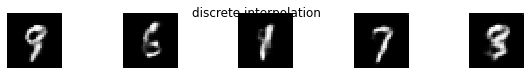

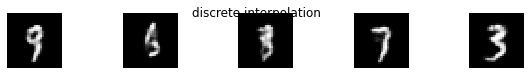

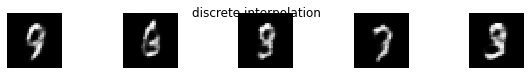

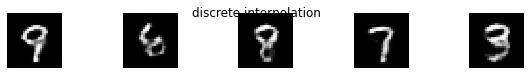

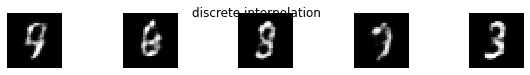

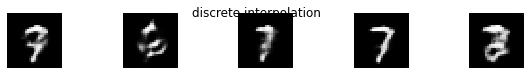

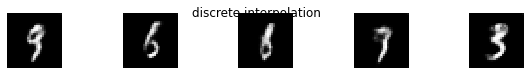

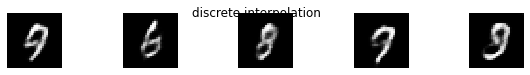

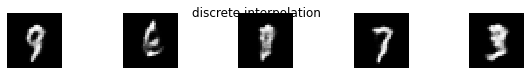

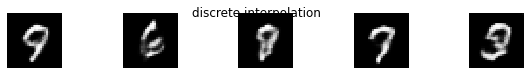

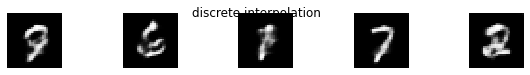

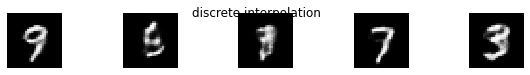

In [29]:
np_z = sess.run(z)

for interp in ('continuous-1', 'continuous-2', 'discrete'):
  # Find the specific variable output
  for i in range(5):
    z_new = np_z.copy()
    z_new[:] = z_new[i:i+1]
    if 'continuous' in interp:
      idx = int(interp.split('-')[1])
      z_new[:10, -idx] = np.linspace(-2, 2, 10)
    else:
      z_new[:cat_dim, noise_dim:noise_dim+cat_dim] = np.eye(cat_dim)

    # Generate samples for displaying
    samples = sess.run(generated_test, {z: z_new})
    display_imgs(samples);
    plt.suptitle(interp + ' interpolation')
    plt.show()